In [153]:
import cv2 as cv
import torch

import xml.etree.ElementTree as ET  
from collections import namedtuple
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt

Glyph = namedtuple('Glyph', 'name bbox')
BBox = namedtuple('Bbox', 'xmin xmax ymin ymax')

# Portion of the kernel that is exclusive to the previous one
STRIDE_RATIO = 0.8
# Amount of staff space added over the staff lines
BOUNDARY_EXTRA = 4
# Minimum amount of samples for training
POLL_THRESH = 200

class MusicFile:
    def __init__(self, filename='', height=0, space=0, column=0, row=0, rot=0, model=[], staff_start=[]):
        self.filename = filename
        self.height = height
        self.space = space
        self.col = column
        self.row = row
        self.rot = rot
        self.model = model
        self.staff_start = staff_start        
    
    def compute_kernel(self):
        assert self.space and self.height and len(self.model)
        
        self.kernel_size = self.space + self.height    
        self.stride = int(self.kernel_size * STRIDE_RATIO)
        self.n_strides_per_staff = int(len(self.model) / self.stride)
        self.boundary_adjust = BOUNDARY_EXTRA * (self.height + self.space)
        self.n_divisions = int(len(self.model) / self.kernel_size)
        
    # Naive implementation because of the small search space
    # No point into implementing a k-d tree
    def locate(self, glyphs, glyph_dict):
        staff_pos = [staff + 2 * (self.space + self.height) + int(self.height / 2) for staff in self.staff_start]
        self.staffs = [[[] for j in range(self.n_divisions)] for  i in range(len(self.staff_start))]
        for glyph in glyphs:
            if glyph_dict[glyph.name] < POLL_THRESH:
                continue
            
            x = int((glyph.bbox.xmin + glyph.bbox.xmax) / 2) - self.col
            y = int((glyph.bbox.ymin + glyph.bbox.ymax) / 2) - self.row
            
            closest_kernel_idx = int(float(x) / len(self.model) * self.n_divisions)
            # We ignore glyphs outside the staff model in column position
            if closest_kernel_idx >= self.n_divisions:
                continue;
            
            min_dist = float('Inf')
            closest_staff_idx = 0
            for i in range(len(staff_pos)):
                dist = abs(y - staff_pos[i])
                if min_dist > dist:
                    min_dist = dist
                    closest_staff_idx = i
                    
            if min_dist > 5 * (self.height + self.space):
                continue
            
            self.staffs[closest_staff_idx][closest_kernel_idx].append(glyph)
    
    def extract_samples(self, img):
        return
    
    def visualize(self, img, glyphs=True, divs=True, labels=True):
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        height, width, channels = img.shape
        if divs:
            for i in range(self.n_divisions):
                img = cv.line(img, (self.col + self.kernel_size * i, 0), 
                         (self.col + self.kernel_size * i, height - 1), (0,0,255), 2)
        
        if glyphs :
            i = 0
            for staff in self.staffs:
                img = cv.rectangle(img, (self.col, self.row + self.staff_start[i]), 
                                   (self.col + len(self.model), self.row + 5 * self.height + 4 * self.space + 
                                    self.staff_start[i]), (0,255,0), 5)
                for division in staff:
                    for glyph in division:
                        img = cv.rectangle(img, 
                        (glyph.bbox.xmin, glyph.bbox.ymin), (glyph.bbox.xmax, glyph.bbox.ymax), (255,0,0), 3)
                        font = cv.FONT_HERSHEY_SIMPLEX
                        if labels:
                            img = cv.putText(img, glyph.name + ' ' + str(i), (glyph.bbox.xmin, glyph.bbox.ymax + 20), 
                                          font, 1, (0,0,255), 1, cv.LINE_AA)
                i += 1
        return img

# Function that parses the staff xml and returns a MusicFile object
def staff_xml(fn):
    tree = ET.parse(fn)
    root = tree.getroot()
    assert root.tag == 'AutoScore'
    
    filename = root[0].text
    height = int(root[1][0].text)
    space = int(root[1][1].text)
    column = int(root[1][2].text)
    row = int(root[1][3].text)
    rot = float(root[1][4].text)
    model = [float(gradient) for gradient in str.split(root[1][5].text)]
    staffs = [int(staff.text) for staff in root[2]]

    return MusicFile(filename, height, space, column, row, rot, model, staffs)

In [154]:
'''
Parsing all the staff description xml files for both datasets that were 
generated by deepscores.cc and muscima.cc binaries
'''
artificial_fn = '../datasets/Artificial/'
artificial_files = [f for f in listdir(artificial_fn) if isfile(join(artificial_fn, f))]
handwritten_fn = '../datasets/Handwritten/'
handwritten_files = [f for f in listdir(handwritten_fn) if isfile(join(handwritten_fn, f))]

artificial_files = [staff_xml(join(artificial_fn, f)) for f in artificial_files]
handwritten_files = [staff_xml(join(handwritten_fn, f)) for f in handwritten_files]

# Parsing both datasets' groundtruths
deepscores_fn = '../../data/DEEPSCORES/images_png/'
deepscores_gt_fn = '../../data/DEEPSCORES/xml_annotations/'
muscima_fn = '../../data/MUSCIMA/CvcMuscima-Distortions/'
muscima_gt_fn = '../../data/MUSCIMA/v1.0/data/cropobjects_manual/'

In [155]:
# Function that parses DEEPSCORES dataset and returns an array of glyphs
deepscores_dict = dict()
def deepscores_gt(filename):
    tree = ET.parse(join(deepscores_gt_fn, os.path.splitext(filename)[0] + '.xml'))
    root = tree.getroot()
    assert root.tag == 'annotation'
    
    width = height = 0
    glyphs = []
    for node in root:
        if node.tag == 'size':
            width = int(node[0].text)
            height = int(node[1].text)
            continue
            
        elif node.tag != 'object':
            continue
            
        assert width and height
        name = node[0].text
        
        if name not in deepscores_dict:
            deepscores_dict[name] = 0
        deepscores_dict[name] += 1
        
        xmin, xmax = int(width * float(node[1][0].text)), int(width * float(node[1][1].text))
        ymin, ymax = int(height * float(node[1][2].text)), int(height * float(node[1][3].text))
        bbox = BBox(xmin, xmax, ymin, ymax)
        glyph = Glyph(name, bbox)
        glyphs.append(glyph)
            
    return glyphs

glyphs = []
for music_file in artificial_files: 
    music_file.compute_kernel()
    glyphs.append(deepscores_gt(music_file.filename))
    
for idx, music_file in enumerate(artificial_files):
    music_file.locate(glyphs[idx], deepscores_dict)

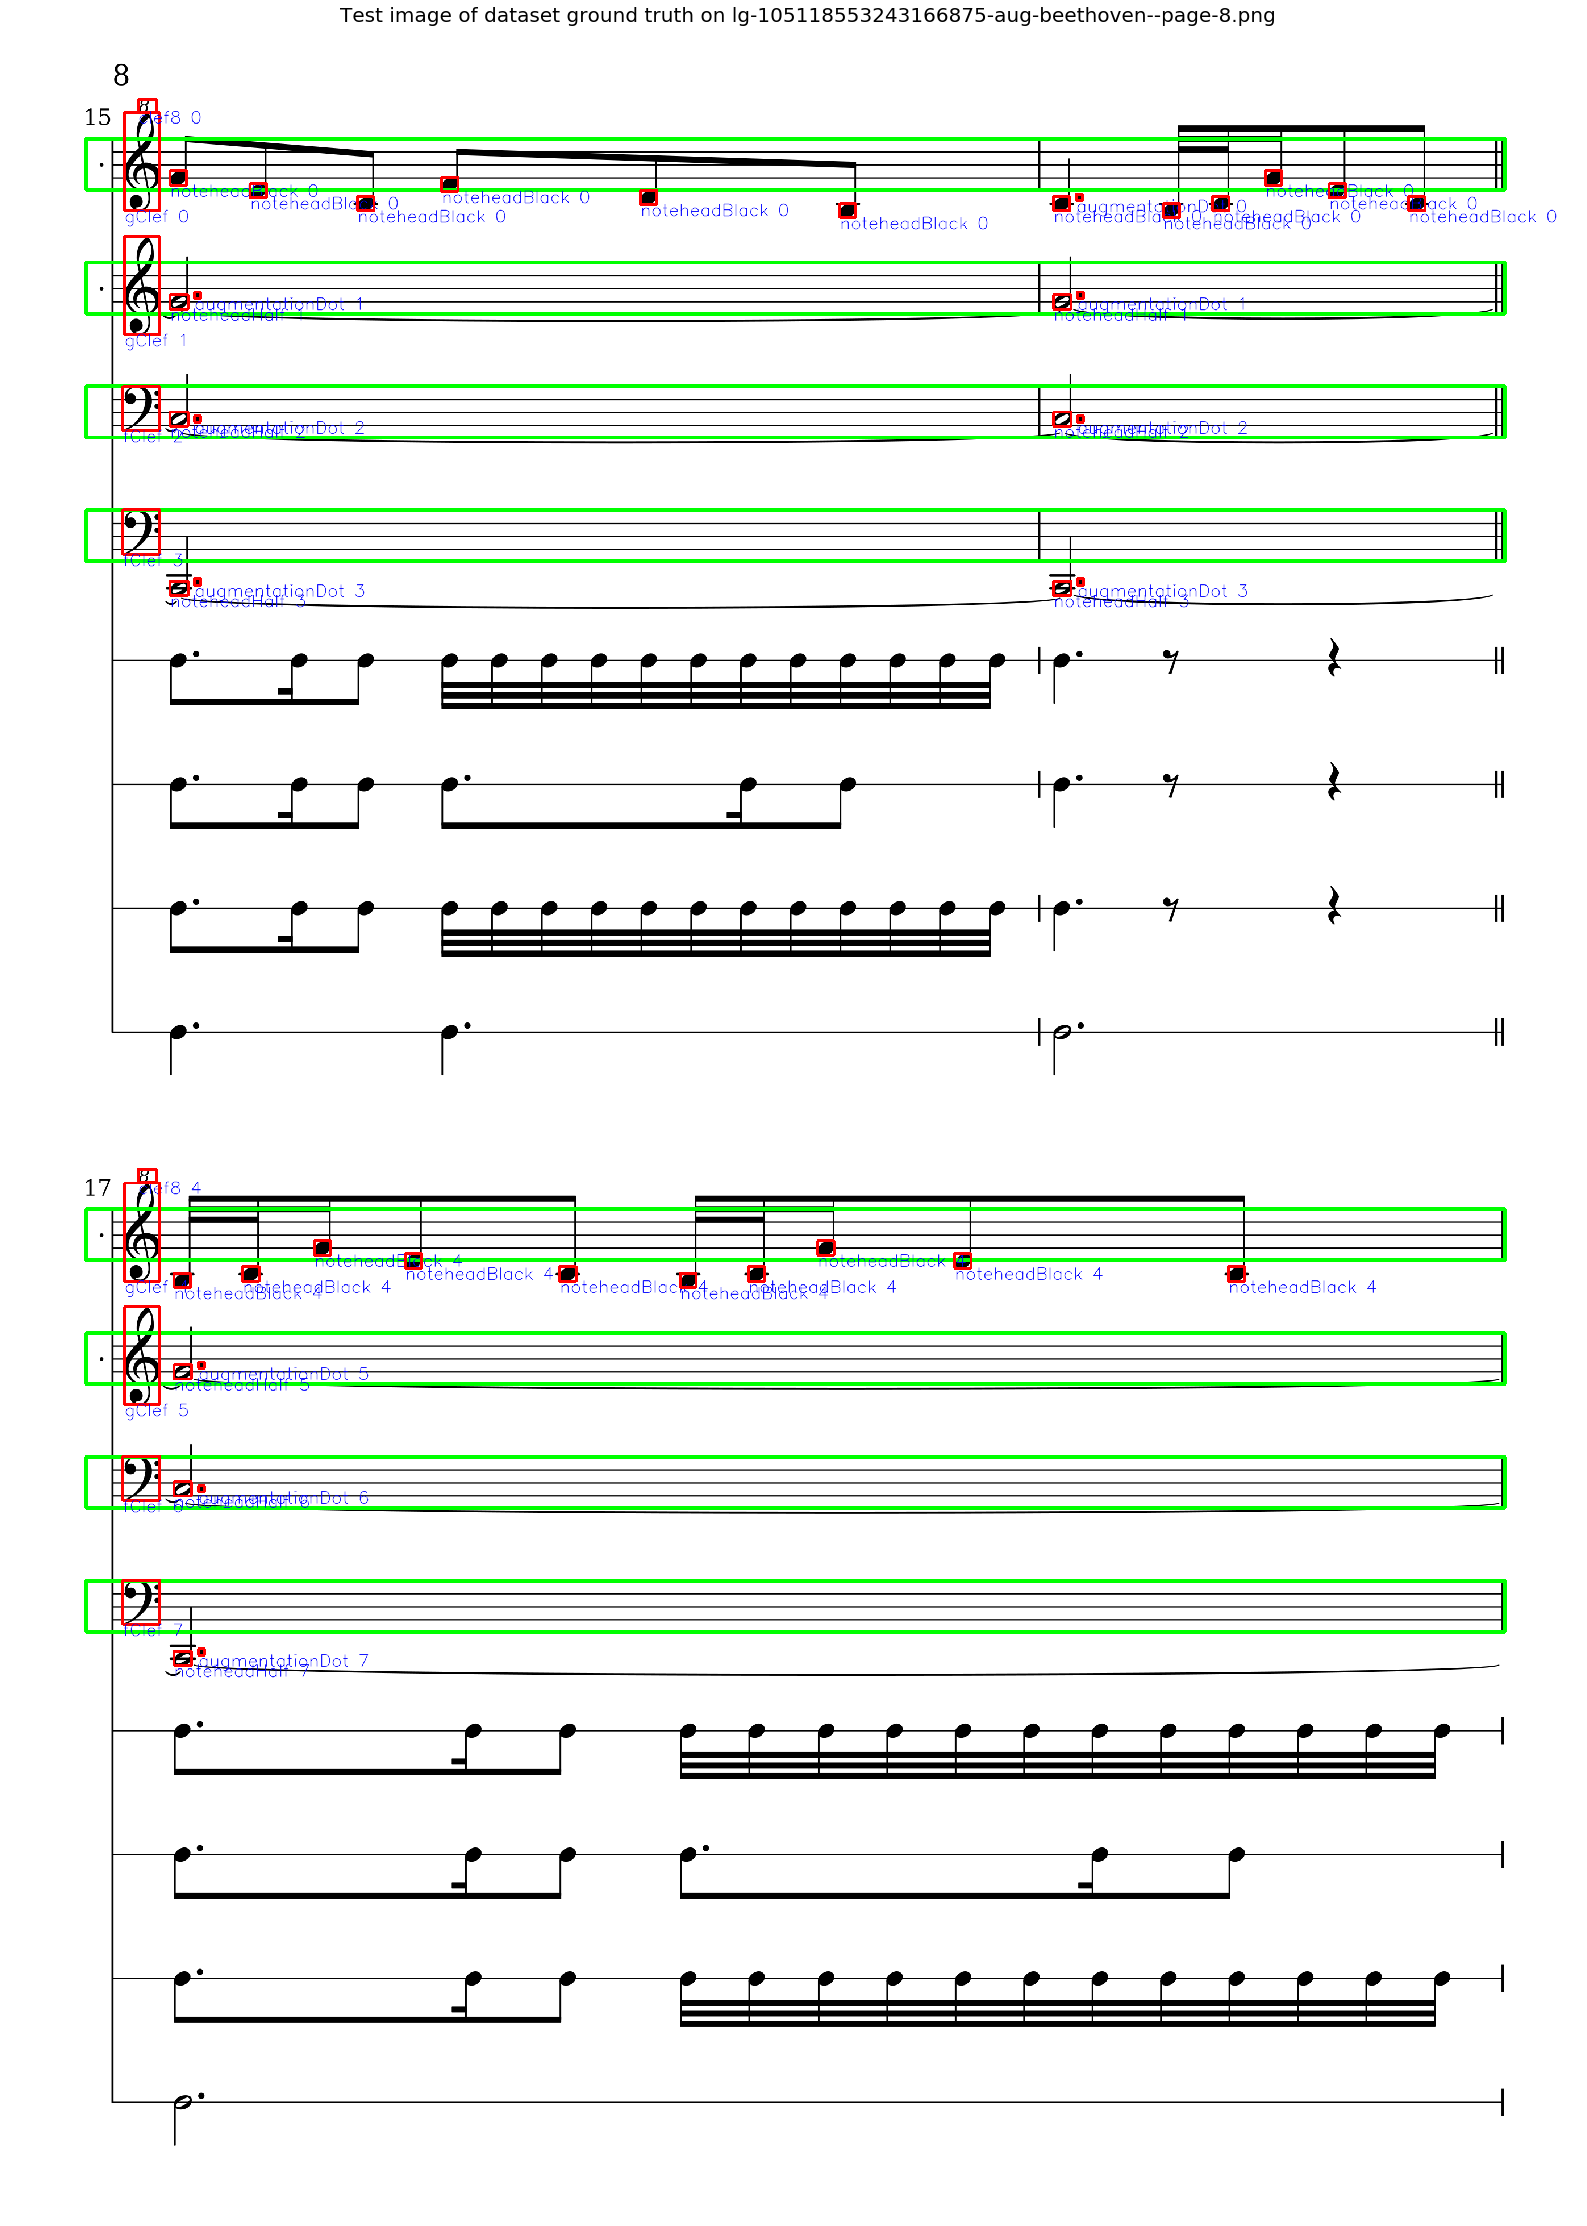

In [156]:
# Visualizing the result
%matplotlib inline

test_filename = artificial_files[0].filename
img = cv.imread(join(deepscores_fn, test_filename), cv.CV_8UC1)
img = artificial_files[0].visualize(img, divs=False)
    
plt.figure(figsize=(40,40))
plt.imshow(img / 255.0);
plt.axis('off')
plt.title('Test image of dataset ground truth on {0}'.format(test_filename),
         fontsize=20);

In [157]:
# Sorting muscima annotated files and their distortions by writer and page
def sort_by_writers(music_files):
    sorted_files = dict()
    for file in music_files:
        pos = file.filename.find('p')
        page = int(file.filename[pos + 1 : pos + 4])
        pos = file.filename.find('W-')
        if (file.filename[pos + 3] != '_'):
            writer = int(file.filename[pos + 2 : pos + 4])
            pos += 4
        else:
            writer = int(file.filename[pos + 2])
            pos += 3
            
        if (writer,page) not in sorted_files:
            sorted_files[(writer,page)] = []
        
        distortion = file.filename[pos + 1:]
        file.filename = distortion + '/w-' + str(writer).zfill(2) + '/image/p' + str(page).zfill(3) + '.png'
            
        sorted_files[(writer, page)].append(file)
    
    return sorted_files

sorted_handwritten_files = sort_by_writers(handwritten_files)

In [158]:
# Functions that parses MUSCIMA dataset and returns an array of glyphs for the ideal set
muscima_dict = dict()
def muscima_gt(filename):
    tree = ET.parse(join(muscima_gt_fn, os.path.splitext(filename)[0] + '.xml'))
    root = tree.getroot()
    assert root.tag == 'CropObjectList'
    
    # For every glyph
    glyphs = []
    for node in root[0]:
        name = node[1].text
        
        if name not in muscima_dict:
            muscima_dict[name] = 0
        muscima_dict[name] += 1
        
        ymin = int(node[2].text)
        xmin = int(node[3].text)
        xmax = xmin + int(node[4].text)
        ymax = ymin + int(node[5].text)
        bbox = BBox(xmin, xmax, ymin, ymax)
        glyphs.append(Glyph(name, bbox))
        
    return glyphs

glyphs = []
for music_file in sorted_handwritten_files: 
    filename = 'CVC-MUSCIMA_W-' + str(music_file[0]).zfill(2) + '_N-' + str(music_file[1]).zfill(2) + '_D-ideal.xml'
    glyphs.append(muscima_gt(filename))
    
for idx, music_file in enumerate(sorted_handwritten_files):
    # Processing each distortion individually
    for file in sorted_handwritten_files[music_file]:
        file.compute_kernel()
        file.locate(glyphs[idx], muscima_dict)

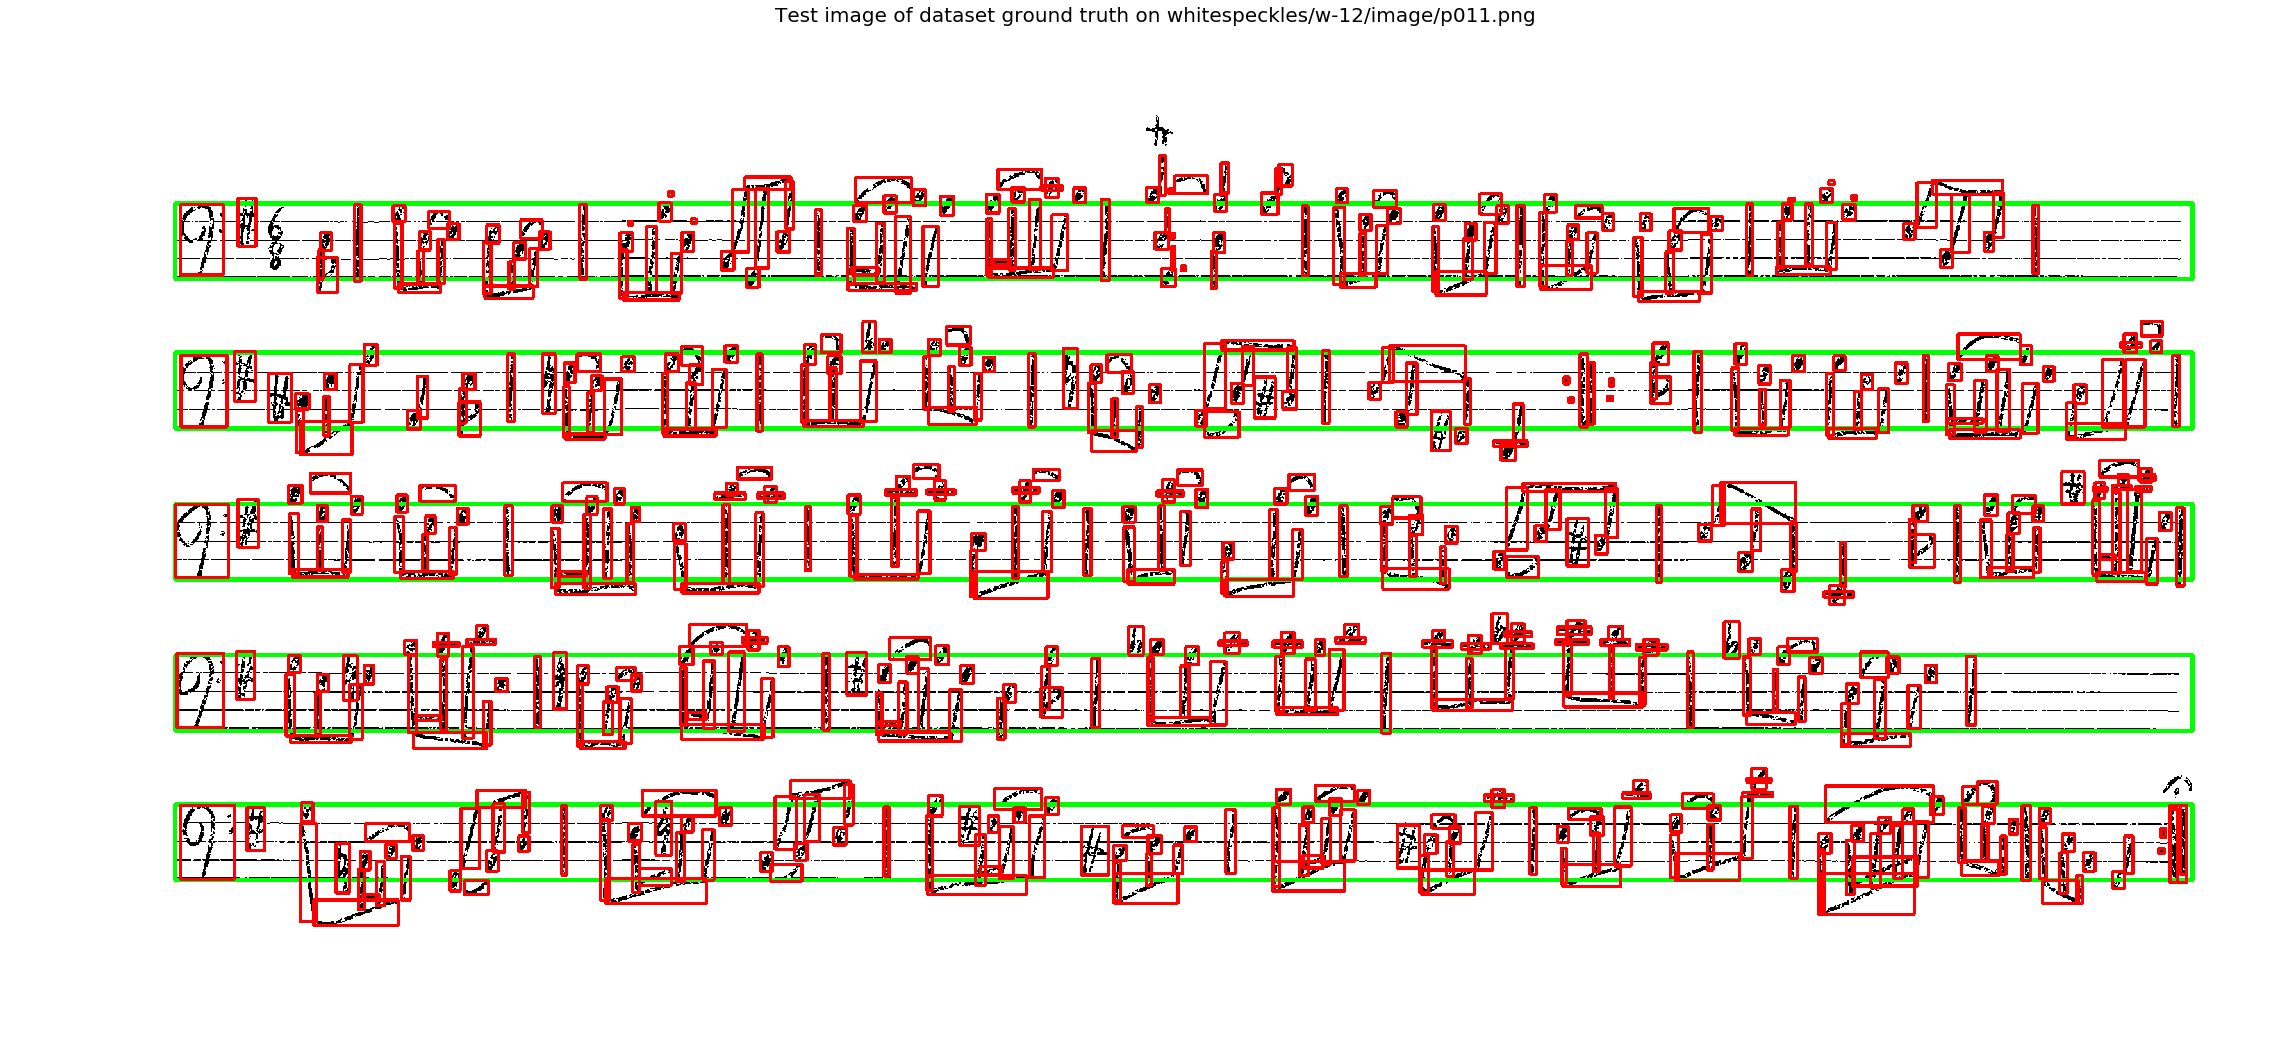

In [159]:
plt.figure(figsize=(40,40))

file = sorted_handwritten_files[list(sorted_handwritten_files.keys())[0]][0]
img = cv.imread(join(muscima_fn, file.filename), cv.CV_8UC1)
_, img = cv.threshold(img, 128, 255, cv.THRESH_BINARY_INV)
img = file.visualize(img, divs=False, labels=False)
plt.axis('off')
plt.imshow(img / 255.0);
plt.title('Test image of dataset ground truth on {0}'.format(file.filename),
         fontsize=20);

In [ ]:
'''
TODO :
1) (DONE) Implement muscima_gt() and sort handwritten_files by writer and page
2) Get correspondance between each dataset's labels or chose what is relevant to the task
3) Morphological transformations to downsample each image
4) Put everything in a python script instead of a notebook
'''

In [134]:
for key in deepscores_dict:
    print('{0} : {1}'.format(key, deepscores_dict[key]))
print('----------------------------------------------------')
for key in muscima_dict:
    print('{0} : {1}'.format(key, muscima_dict[key]))

noteheadBlack : 122376
noteheadHalf : 10171
augmentationDot : 7370
restQuarter : 4975
rest8th : 5432
gClef : 5901
clef8 : 720
fClef : 3020
flag8thUp : 3146
accidentalSharp : 3507
flag16thUp : 735
accidentalNatural : 2474
flag32ndUp : 113
rest32nd : 646
rest16th : 2796
dynamicMF : 330
accidentalFlat : 1761
tuplet3 : 971
keyFlat : 7625
brace : 1502
restWhole : 7902
restHalf : 1698
flag16thDown : 831
timeSig3 : 209
timeSig8 : 108
keySharp : 6016
timeSigCommon : 485
repeatDot : 952
timeSig4 : 1408
arpeggiato : 62
flag8thDown : 3457
timeSig5 : 40
noteheadWhole : 3149
fClefChange : 57
fermataAbove : 161
timeSig2 : 151
caesura : 61
dynamicPiano : 210
dynamicFFF : 80
cClefAlto : 204
dynamicFF : 165
dynamicForte : 323
unpitchedPercussionClef1 : 295
articAccentBelow : 536
articStaccatoBelow : 1860
stringsUpBow : 15
articStaccatoAbove : 2163
articTenutoAbove : 160
stringsDownBow : 11
dynamicMP : 273
rest128th : 39
rest64th : 816
restHBar : 216
clef15 : 26
flag64thUp : 52
accidentalDoubleSharp : 1